In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# ダミーデータの作成
np.random.seed(0)
X = np.random.rand(100, 3)  # 説明変数が3つあるデータセット
y = 3*X[:,0] + 2*X[:,1] + X[:,2] + np.random.randn(100)  # 目的変数

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# モデルの作成と訓練
model = LinearRegression()
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# モデルの評価
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.9251139326904528
R^2 Score: 0.5542730826666373


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import librosa
import librosa.display

import dataProcesser as dp

lis = ['usedvoice/man1(50)1.wav',
       'usedvoice/woman1(low)2.wav',
       'usedvoice/man2(45)3.wav',
       'usedvoice/woman2(high)(90)4.wav',
       'usedvoice/man3(6)5.wav',
       'usedvoice/woman3(midle)(60)6.wav',
       'usedvoice/man4(47)7.wav',
       'usedvoice/woman4(35)8.wav']

features_dic = {"db_maen": [],
                "db_std": [],
                "freq_mean": [],
                "freq_std": [],
                "active_time": [],
                "silent_time": [],
                "sl_time_std": [],
                "jitter_mean": [],
                "jitter_std": [],
                **{f"mfcc_{i+1}_mean":[] for i in range(13)},
                **{f"mfcc_{i+1}_std":[] for i in range(13)}
                }
for path in lis:
    y, sr = librosa.load(path)
    active_segments = dp.get_active_segments(y)
    db_mean, db_std = dp.get_db_features(active_segments)
    features_dic["db_maen"].append(db_mean)
    features_dic["db_std"].append(db_std)
    features_dic["active_time"].append(dp.get_speaking_time(y))
    silents_time, sl_time_std = dp.get_silent_time(y)
    features_dic["silent_time"].append(silents_time)
    features_dic["sl_time_std"].append(sl_time_std)
    freq_mean, freq_std, jitter_mean, jitter_std = dp.get_f0_features(active_segments)
    features_dic["freq_mean"].append(freq_mean)
    features_dic["freq_std"].append(freq_std)
    features_dic["jitter_mean"].append(jitter_mean)
    features_dic["jitter_std"].append(jitter_std)
    mfcc_mean, mfcc_std = dp.get_mfcc_features(active_segments)
    for i in range(13):
        features_dic[f"mfcc_{i+1}_mean"].append(mfcc_mean[i])
        features_dic[f"mfcc_{i+1}_std"].append(mfcc_std[i])

In [4]:
data = pd.read_csv('data.csv', encoding='utf-8')
median_data = np.array(data.iloc[1, 1:])
median_list = np.array([median_data[i*8:i*8+8] for i in range(15)]).astype(np.float32)
mean_data = np.array(data.iloc[0, 1:])
mean_list = np.array([mean_data[i*8:i*8+8] for i in range(15)]).astype(np.float32)
mode_data = np.array(data.iloc[2, 1:])
mode_list = np.array([mode_data[i*8:i*8+8] for i in range(15)]).astype(np.float32)
head_names = list(data.head(0))[1:]
head_names = [head_names[i*8:i*8+8] for i in range(15)]
head_list = [tmp[0][:-3] for tmp in head_names]

features = list(features_dic.values())
feature_names = list(features_dic.keys())
correlation_matrix = np.corrcoef(mean_list, features)[:len(median_list), len(median_list):]

correlation_df = pd.DataFrame(correlation_matrix, index=head_list, columns=feature_names).T.round(3)

ranking_df = pd.DataFrame()
ranking_num_df = pd.DataFrame()

lis = []
for col in correlation_df.columns:
    sorted_col = correlation_df[col].abs().sort_values(ascending=False).index
    lis.append(sorted_col)

In [5]:
ranks = np.array(lis)

In [6]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
rank1_list = ranks[:,0]
rank2_list = ranks[:,1]
for i in range(15):
    feature_1 = np.array(features_dic[rank1_list[i]])
    feature_2 = np.array(features_dic[rank1_list[i]])
    X = np.array([feature_1, feature_2]).T
    y = mean_list[i]
    print(head_list[i])
    print(f"Feature 1: {rank1_list[i]}, Feature 2: {rank2_list[i]}")

    # 4分割交差検証のためのKFoldオブジェクトを作成
    kf = KFold(n_splits=4, shuffle=True, random_state=0)

    # 決定係数とRMSEを格納するリスト
    r2_scores = []
    rmse_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # 標準化のためのスケーラーを作成
        scaler = StandardScaler()
        
        # 訓練データを標準化
        X_train = scaler.fit_transform(X_train)
        
        # テストデータを標準化
        X_test = scaler.transform(X_test)
        
        # モデルの作成と訓練
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # 予測
        y_pred = model.predict(X_test)
        
        # 決定係数とRMSEを計算
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # 決定係数とRMSEをリストに格納
        r2_scores.append(r2)
        rmse_scores.append(rmse)

    # 決定係数とRMSEを表示
    for i, (r2, rmse) in enumerate(zip(r2_scores, rmse_scores)):
        print(f"Fold {i+1} - R^2: {r2}, RMSE: {rmse}")
    # 決定係数とRMSEの平均を計算
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmse_scores)
    print(f"Mean R^2: {mean_r2}")
    print(f"Mean RMSE: {mean_rmse}")
    print()

かすれ度合
Feature 1: sl_time_std, Feature 2: silent_time
Fold 1 - R^2: 0.18818116067772517, RMSE: 0.6982826597791175
Fold 2 - R^2: -13.954616106393251, RMSE: 0.6187392842935361
Fold 3 - R^2: -2.1977242635133174, RMSE: 0.31293831322663734
Fold 4 - R^2: 0.11431108604545359, RMSE: 0.3152720433229603
Mean R^2: -3.962462030795847
Mean RMSE: 0.4863080751555628

この声は好みか
Feature 1: mfcc_3_mean, Feature 2: mfcc_10_mean
Fold 1 - R^2: -109.79647863349105, RMSE: 0.21051961183547974
Fold 2 - R^2: 0.6114857526065974, RMSE: 0.2836056053638458
Fold 3 - R^2: -0.9748875609674355, RMSE: 0.35835325717926025
Fold 4 - R^2: -1.985018105854564, RMSE: 0.29371240735054016
Mean R^2: -28.03622463692661
Mean RMSE: 0.2865477204322815

ボリューム
Feature 1: mfcc_13_mean, Feature 2: db_maen
Fold 1 - R^2: 0.5616835227347778, RMSE: 0.17544449865818024
Fold 2 - R^2: 0.5867287822544938, RMSE: 0.09964355081319809
Fold 3 - R^2: -0.8282155116896734, RMSE: 0.29746538400650024
Fold 4 - R^2: 0.044358320667887696, RMSE: 0.21017743647098

In [7]:
# feature_1を使用した単回帰分析
X_single_1 = feature_1.reshape(-1, 1)

# 決定係数とRMSEを格納するリスト
r2_scores_single_1 = []
rmse_scores_single_1 = []

for train_index, test_index in kf.split(X_single_1):
    X_train, X_test = X_single_1[train_index], X_single_1[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 標準化のためのスケーラーを作成
    scaler = StandardScaler()
    
    # 訓練データを標準化
    X_train = scaler.fit_transform(X_train)
    
    # テストデータを標準化
    X_test = scaler.transform(X_test)
    
    # モデルの作成と訓練
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # 予測
    y_pred = model.predict(X_test)
    
    # 決定係数とRMSEを計算
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # 決定係数とRMSEをリストに格納
    r2_scores_single_1.append(r2)
    rmse_scores_single_1.append(rmse)

# 決定係数とRMSEを表示
print("Single Regression with feature_1")
for i, (r2, rmse) in enumerate(zip(r2_scores_single_1, rmse_scores_single_1)):
    print(f"Fold {i+1} - R^2: {r2}, RMSE: {rmse}")
# 決定係数とRMSEの平均を計算
mean_r2_single_1 = np.mean(r2_scores_single_1)
mean_rmse_single_1 = np.mean(rmse_scores_single_1)
print(f"Mean R^2: {mean_r2_single_1}")
print(f"Mean RMSE: {mean_rmse_single_1}")

# feature_2を使用した単回帰分析
X_single_2 = feature_2.reshape(-1, 1)

# 決定係数とRMSEを格納するリスト
r2_scores_single_2 = []
rmse_scores_single_2 = []

for train_index, test_index in kf.split(X_single_2):
    X_train, X_test = X_single_2[train_index], X_single_2[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 標準化のためのスケーラーを作成
    scaler = StandardScaler()
    
    # 訓練データを標準化
    X_train = scaler.fit_transform(X_train)
    
    # テストデータを標準化
    X_test = scaler.transform(X_test)
    
    # モデルの作成と訓練
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # 予測
    y_pred = model.predict(X_test)
    
    # 決定係数とRMSEを計算
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # 決定係数とRMSEをリストに格納
    r2_scores_single_2.append(r2)
    rmse_scores_single_2.append(rmse)

# 決定係数とRMSEを表示
print("Single Regression with feature_2")
for i, (r2, rmse) in enumerate(zip(r2_scores_single_2, rmse_scores_single_2)):
    print(f"Fold {i+1} - R^2: {r2}, RMSE: {rmse}")
# 決定係数とRMSEの平均を計算
mean_r2_single_2 = np.mean(r2_scores_single_2)
mean_rmse_single_2 = np.mean(rmse_scores_single_2)
print(f"Mean R^2: {mean_r2_single_2}")
print(f"Mean RMSE: {mean_rmse_single_2}")

Single Regression with feature_1
Fold 1 - R^2: 0.9407922595707418, RMSE: 0.14356258511543274
Fold 2 - R^2: 0.33649426012101813, RMSE: 0.448007196187973
Fold 3 - R^2: -0.8202435982026939, RMSE: 0.7150568962097168
Fold 4 - R^2: -3.023433680149042, RMSE: 0.7421644330024719
Mean R^2: -0.641597689664994
Mean RMSE: 0.5121977925300598


Single Regression with feature_2
Fold 1 - R^2: 0.9407922595707418, RMSE: 0.14356258511543274
Fold 2 - R^2: 0.33649426012101813, RMSE: 0.448007196187973
Fold 3 - R^2: -0.8202435982026939, RMSE: 0.7150568962097168
Fold 4 - R^2: -3.023433680149042, RMSE: 0.7421644330024719
Mean R^2: -0.641597689664994
Mean RMSE: 0.5121977925300598


In [8]:
X_standard = scaler.transform(X)
plt.scatter(X_standard[:, 0], X_standard[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='y')
plt.show()

ValueError: X has 2 features, but StandardScaler is expecting 1 features as input.

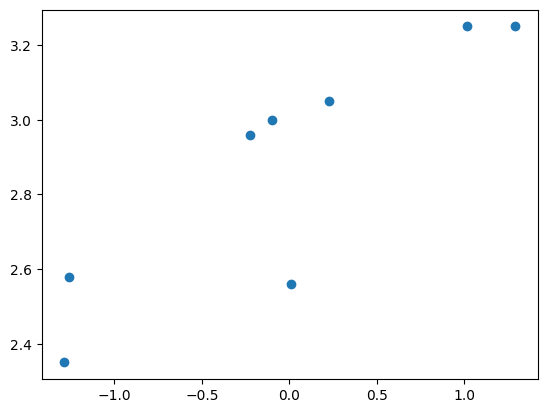

In [ ]:
plt.plot(X_standard[:, 0], y, 'o', label='Feature 1')
plt.show()